In [75]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import RandomSampler, random_split, SubsetRandomSampler, WeightedRandomSampler

"""Change to the data folder"""
new_path = "./new_train/new_train"
val_path = "./new_val_in/new_val_in" 
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

In [2]:
torch.cuda.is_available()

True

### Create a dataset class 

In [80]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=new_path)

### Create a loader to enable batch processing

In [81]:
batch_sz = 32

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    out = torch.LongTensor(out)
    inp = torch.tensor(inp, dtype=torch.float)
    out = torch.tensor(out, dtype=torch.float)
    return [inp, out]

train_dataset, val_dataset = random_split(train_dataset, (199078, 6864))

sampler = RandomSampler(train_dataset, num_samples = 6000, replacement=True)
# sampler = RandomSampler(train_dataset)

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0, sampler = sampler, drop_last=True)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0, drop_last=True)


In [82]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)

        return out
    

In [83]:
from tqdm.notebook import tqdm
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    iterator = tqdm(train_loader, total=int(len(train_loader)))
    loss_ema = -1
    for batch_idx, (data, target) in enumerate(iterator):
        data, target = torch.reshape(data, (batch_sz, 60, -1)).to(device), torch.reshape(target[:,:,:,:2], (batch_sz, 60, -1)).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.sqrt(nn.MSELoss()(output, target))
        loss.backward()
        optimizer.step()
        if loss_ema < 0:
            loss_ema = loss.item()
        loss_ema = loss_ema * 0.99 + loss.item()*0.01
        iterator.set_postfix(loss=loss_ema)
    return loss_ema

In [84]:
def test(model, device, test_loader):
    model.eval()
    loss_ema = -1
    with torch.no_grad():
        for data, target in test_loader:
            data, target = torch.reshape(data, (batch_sz, 60, -1)).to(device), torch.reshape(target[:,:,:,:2], (batch_sz, 60, -1)).to(device)
            output = model(data)
            loss = torch.sqrt(nn.MSELoss()(output, target))
            if loss_ema < 0:
                loss_ema = loss.item()
            loss_ema = loss_ema * 0.99 + loss.item()*0.01
    print("Test loss: {}".format(loss_ema))

In [86]:
input_dim = 76
output_dim = 60  

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
    
learning_rate = 0.0001
momentum = 0.5

In [87]:
net = NN(input_dim, output_dim)
model = net.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum, weight_decay=1e-5)
num_epoch = 10
losses = []
for epoch in range(1, num_epoch + 1):
    loss = train(model, device, train_loader, optimizer, epoch)
    losses.append(loss)
    test(model, device, val_loader)
    torch.save(model.state_dict(), 'checkpoints/train-epoch-linear-lower-learning{}.pth'.format(epoch + 1)) 
    
with open("losses_test_linear-lower-learning.txt", "w") as output:
    output.write(str(losses))

  0%|          | 0/187 [00:00<?, ?it/s]

<ipython-input-81-392220d32f10>:7: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = torch.LongTensor(out)
<ipython-input-81-392220d32f10>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(out, dtype=torch.float)


Test loss: 11.467475410379167


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 11.643122683268738


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 12.849795994062607


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 9.428726448277734


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 14.176584561754273


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 9.6620364615582


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 10.993848837909994


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 10.546199451775074


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 13.996167126460541


  0%|          | 0/187 [00:00<?, ?it/s]

Test loss: 5.451176601592597


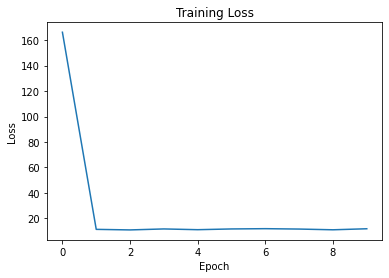

In [88]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('eda_results/training_subset_linear-lower-learning.png')

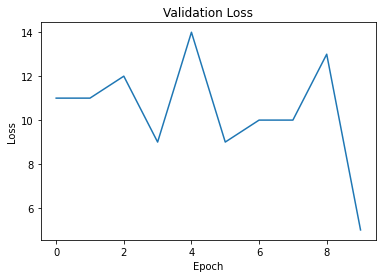

In [90]:
test_loss = [11, 11, 12, 9, 14, 9, 10, 10, 13, 5]

plt.plot(test_loss)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('eda_results/test_subset_linear-lower-learning.png')

## Test and predict

In [91]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [92]:
batch_sz = 4

def my_test_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
#     print(batch)
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = torch.tensor(inp, dtype=torch.float)
    agent = [scene['agent_id'] for scene in batch]
    track = [scene['track_id'] for scene in batch]
    track_ids = []
    for scene in range(len(agent)):
        for track_id in range(len(track[scene])):
            if agent[scene] == track[scene][track_id][0][0]:
                track_ids.append(track_id)
                break
    return [inp, track_ids]

# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=val_path)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_test_collate, num_workers=0, drop_last=True)


In [93]:
def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    with torch.no_grad():
        for data, agent in test_loader:
            data = torch.reshape(data, (4, 60, -1)).to(device)
            output = torch.reshape(model(data), (4, 60, 30, -1))
            for i in range(len(agent)):
                scene = output[i][agent[i]]
                predictions.append(scene)
    predict = [torch.reshape(t, (-1,)) for t in predictions]
    sample = pd.read_csv('sample_submission.csv')
    preds_df = sample.set_index('ID')
    for i in range(3200):
        preds_df.iloc[i] = predict[i].tolist()
    return preds_df

In [95]:
net = NN(input_dim, output_dim)
model = net.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum, weight_decay=1e-5)
net.load_state_dict(torch.load("checkpoints/train-epoch-linear-lower-learning11.pth",map_location=device))
model = net.to(device)
preds = predict(model, device, val_loader)

In [96]:
preds.to_csv('test_preds_linear-lower-learning11.csv')

In [97]:
preds.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
ID,,,,,,,,,,,,,,,,,,,,,
10002,1706.160645,333.418884,1707.764526,327.226440,1704.670776,336.969025,1700.612305,334.226349,1704.027344,330.474884,...,1709.344360,348.234802,1703.524414,346.118927,1709.697998,345.974396,1699.392456,350.419037,1705.004272,351.947968
10015,728.576904,1228.781616,722.767578,1233.504761,725.635010,1230.040161,726.430603,1231.975952,727.808350,1231.715088,...,723.009155,1229.996826,725.052124,1230.367310,725.295227,1231.436890,723.978394,1230.067871,725.914246,1231.117920
10019,570.078308,1244.290283,571.834290,1243.655518,571.864441,1244.224487,570.082947,1244.678345,572.629639,1244.290405,...,572.712646,1243.632324,569.932068,1242.535767,571.575806,1243.040649,569.787048,1242.248047,571.136597,1241.924438
10028,1686.107422,313.908691,1685.139526,310.522308,1685.287231,314.161469,1681.083496,313.903259,1684.617065,314.757843,...,1687.707397,327.891083,1684.803223,324.620605,1687.080322,330.067902,1680.284546,328.595184,1682.929565,331.234680
1003,2145.673096,689.003296,2127.127686,703.304504,2135.640381,679.399048,2137.571289,692.217651,2139.687256,696.269714,...,2119.270996,692.606018,2138.678223,696.936218,2132.155518,705.575928,2142.156494,703.995544,2133.557617,712.105408


### Visualize Predictions

In [276]:
batch_sz = 1

def my_viz_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
#     print(batch)
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    inp = torch.tensor(inp, dtype=torch.float)
    agent = [scene['agent_id'] for scene in batch]
    track = [scene['track_id'] for scene in batch]
    out = [scene['p_out'] for scene in batch]
    out = torch.tensor(out, dtype=torch.float)
    track_ids = []
    for scene in range(len(agent)):
        for track_id in range(len(track[scene])):
            if agent[scene] == track[scene][track_id][0][0]:
                track_ids.append(track_id)
                break
    return [inp, out, track_ids[0]]

# intialize a dataset
viz_dataset  = ArgoverseDataset(data_path=new_path)
viz_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = True, collate_fn=my_viz_collate, num_workers=0, drop_last=True)

In [277]:
for inp, out, track_ids in viz_loader:
    break

In [278]:
def visualize_predict(model, device, inp, agent, out):
    model.eval()
    with torch.no_grad():
        data = torch.reshape(inp, (1, 60, -1)).to(device)
        output = torch.reshape(model(data), (1, 60, 30, -1))
        fig, axs = plt.subplots(1,2, figsize=(15, 3), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = .5, wspace=.1)
        axs[0].xaxis.set_ticks([])
        axs[0].yaxis.set_ticks([])
        
        axs[1].xaxis.set_ticks([])
        axs[1].yaxis.set_ticks([])
        
        axs[0].scatter(inp[0, agent,:,0], inp[0, agent,:,1])
        axs[0].scatter(out[0, agent,:,0], out[0, agent,:,1])
        plt.title('Ground Truth')
        
        
        axs[1].scatter(inp[0, agent,:,0], inp[0, agent,:,1])
        axs[1].scatter(output[0, agent,:,0], output[0, agent,:,1])
        plt.title('Predicted')
#         axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])

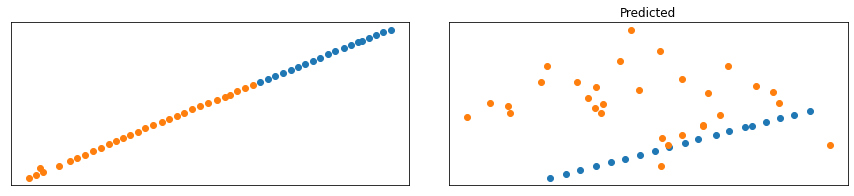

In [279]:
visualize_predict(model, device, inp, track_ids, out)
i += 1
plt.savefig('eda_results/example_output{}.png'.format(i))

In [263]:
i = 0